## Error Analysis: Scene types

- Clean up raw scene names
- Build Scene:doc -- Object:term
- Map object to scene(s)
- Report scene-wise performance

In [18]:
import os
import numpy as np
import pandas as pd
from collections import Counter
from utils import read_json, sort_dict

In [19]:
path = os.path.join(os.environ['VG'], 'region_ros.json')

jsn = read_json(path)
inp = read_json('./img2scene.json')

### Clean Scene names

In [20]:
_REMOVE = ['a', 'an', 'the', 'at', 'in', 'front', 'of', 'on', 'by', 'side', 'along', 'corner',
          'outside', 'inside', 'next', 'near', 'top', 'under', "someone's", "person's"]

skip = 'texas,india,china,japan,hong kong,england,germany,italy,australia,london,paris,amsterdam,san francisco,washington dc,new orleans,pen,hand'
skip = skip.split(',')

def _clean(s: str):
    s = s.split()
    for w in _REMOVE:
        if w in s:
            s.remove(w)
    return ' '.join(s)

In [21]:
scenes = [_clean(s) for s in inp.values()]

scenes = dict(Counter([s for s in scenes if s not in skip]))

In [22]:
scn_low_freq = {s: f for s, f in scenes.items() if f < 10}

sum(scn_low_freq.values()), len(scenes) - len(scn_low_freq)

(3364, 384)

In [23]:
raw2clean = 'city:street,city street:street,africa:savannah,new york:street,new york city:street,the street:street,busy street:street,' + \
            'starbucks:coffee shop,large body water:water,the road:road,alleyway:alley,body water:water,wooded area:woods,' + \
            'small town:rural area,pizza parlor:pizzeria,public bathroom:public restroom,skatepark:skate park,tree:trees,' + \
            'railroad track:railroad,railroad tracks:railroad,shopping mall:mall,shopping center:mall,swimming pool:pool,' + \
            'train track:train tracks,wedding reception:wedding,tennis match:tennis court,window sill:windowsill'

raw2clean = {s.split(':')[0]: s.split(':')[1] for s in raw2clean.split(',')}

In [24]:
# Rename / Remove scenes
img2scn = {}

for im, scn in inp.items():
    scn = _clean(scn)

    if scn in skip or scenes[scn] < 10:
        scn = 'SKIP'

    if scn in raw2clean:
        scn = raw2clean[scn]

    img2scn[im] = scn

img2scn = {int(im): scn for im, scn in img2scn.items() if scn not in ['', 'SKIP']}

len(set(img2scn.values()))

357

In [25]:
Counter(img2scn.values()).most_common(30)


[('street', 11579),
 ('restaurant', 4716),
 ('field', 4213),
 ('kitchen', 4207),
 ('house', 3910),
 ('beach', 3837),
 ('park', 3716),
 ('zoo', 3384),
 ('bathroom', 3214),
 ('building', 3197),
 ('tennis court', 2980),
 ('ski slope', 2684),
 ('baseball field', 2543),
 ('living room', 2435),
 ('train station', 2193),
 ('ocean', 2127),
 ('bedroom', 1983),
 ('sidewalk', 1953),
 ('airport', 1925),
 ('parking lot', 1745),
 ('table', 1473),
 ('savannah', 1388),
 ('office', 1367),
 ('skate park', 1209),
 ('river', 996),
 ('road', 853),
 ('water', 850),
 ('woods', 846),
 ('sky', 803),
 ('hotel room', 749)]

In [26]:
MIN_SCENE_FREQ = 100

scenes = {s: f for s, f in scenes.items() if f >= MIN_SCENE_FREQ}

len(scenes)

100

<br>

### Object-Scene relations

- Frequent Objects per scene
- Object Class density per scene


In [27]:
from tqdm import tqdm

scene2objects = {}

for d in tqdm(jsn):
    _id = d['image_id']
    regs = d['ros']
    if _id in img2scn:
        scn = img2scn[_id]
        objs = []
        for r in regs:
            objs += list(r.values())

        if scn not in scene2objects:
            scene2objects[scn] = []

        scene2objects[scn] += objs

100%|██████████| 108077/108077 [00:01<00:00, 72404.49it/s]


In [28]:
scene2objects = {scn: dict(Counter(objs)) for scn, objs in scene2objects.items()}

In [29]:
scn2obj_freq = {s: (np.mean(list(o.values())), np.std(list(o.values()))) for s, o in scene2objects.items()}

### Model Performance

#### R-Acc

In [67]:
test = read_json('../dataset/color/test.json')

SCORE = {'bert': 66.87, 'clip': 79.96}

In [75]:
MODEL = 'clip'

df = pd.read_csv(f'../temp/{MODEL}_col.csv')

df['pred'] = df['pred'].apply(lambda x: str(x))
df['correct'] = df.apply(lambda x: x['pred'] in x['true'], axis=1)

obj2correct = {o: c for o, c in zip(list(test), df['correct'].tolist())}

In [76]:
scene2acc = {}
for scn, objs in scene2objects.items():
    if scn in scenes:
        correct = [obj2correct[o] for o in objs if o in obj2correct]
        scene2acc[scn] = np.mean(correct)

# scene2acc = sort_dict(scene2acc, by='v', reverse=True)
scene2acc = sort_dict(scene2acc, by='k', reverse=True)

#### Bar Plot

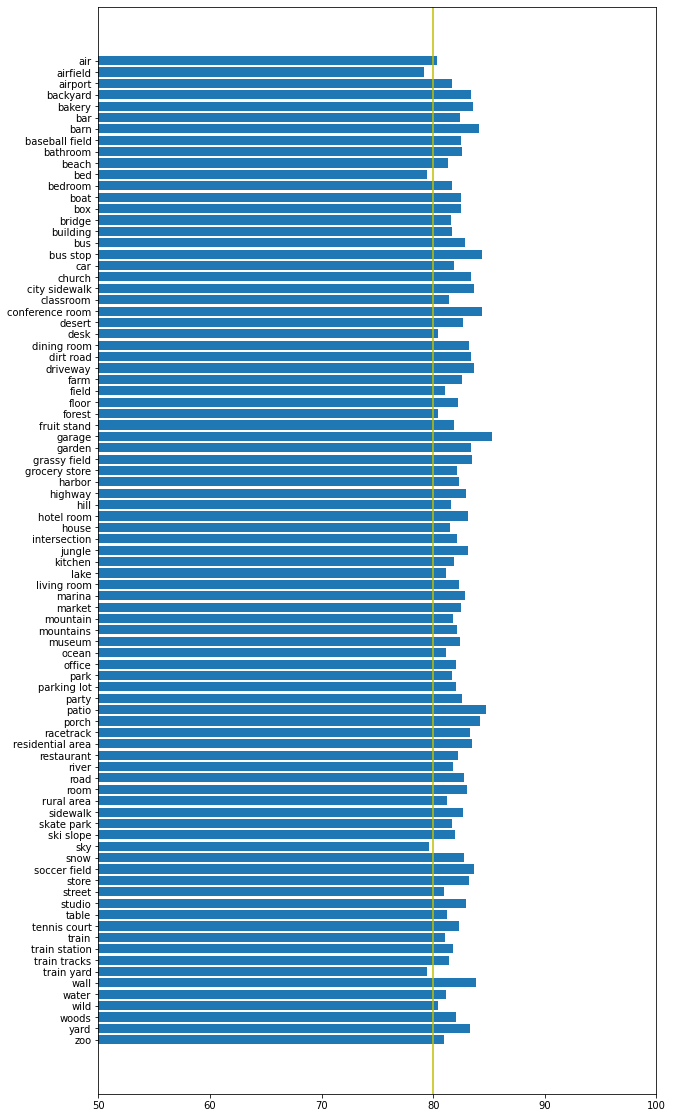

In [77]:
import matplotlib.pyplot as plt

def _scale(arr, by=100):
    return [_ * by for _ in arr]

plt.figure(figsize=(10,20))

# inputs
scores = _scale(scene2acc.values())
bars = scene2acc

y_pos = np.arange(len(bars))

# horizontal bars
plt.barh(y_pos, scores)
plt.xlim([50, 100])

plt.yticks(y_pos, bars)

# mean score
plt.axvline(x=SCORE[MODEL],color='y')

# plt.show()
plt.savefig(f'err_scene_{MODEL}.pdf', bbox_inches='tight')